In [1]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Using TensorFlow backend.


In [2]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

# Image Augmentation & Preprocessing

## Understanding images and channels

As the image are RGB images they constitue three channels - one for each of the color channels

In [3]:
# path to the dataset
DATASET_PATH = './small_dataset_train/'
flowers_cls = ['train']

The glob module of python is used to walk through the directory, subdirectories and the files where the data is stored

In [4]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[0], '*.jpg')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[3]) # access an individual file

./small_dataset_train/train/*.jpg
./small_dataset_train/train/5765.jpg


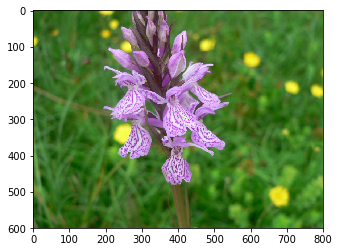

In [5]:
# visualising a randomly chosen image of a rose from the data set
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

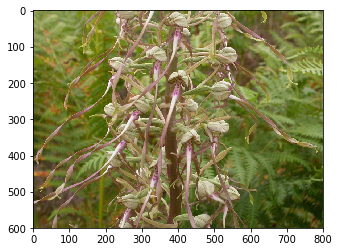

In [6]:

# plot a sample image
flower_path = os.path.join(DATASET_PATH, flowers_cls[0], '*.jpg')
flower_path = glob.glob(flower_path)

# access some element (a file) from the list
image = io.imread(flower_path[529])
plt.imshow(image)

In [7]:
print(image.shape)

(600, 800, 3)


Text(0.5, 0.98, 'Different Channels of Image')

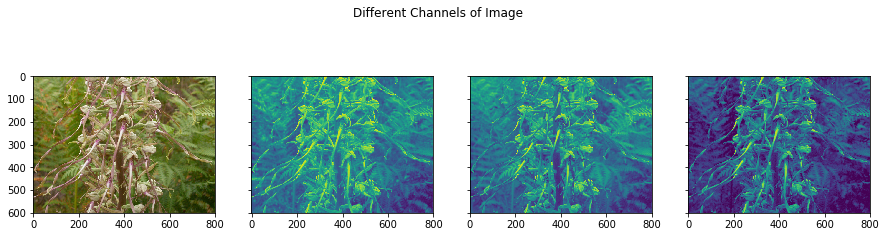

In [8]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

# Morphological Transformations

## Thresholding

Taking all the pixels whose intensities are above a certain threshold and converting them to ones; the pixels having values less than the threeshold are converted to zero. This result in a binary image

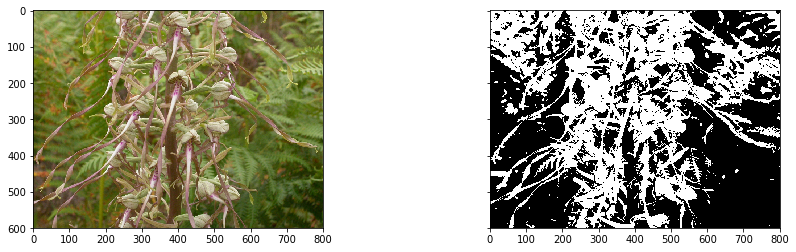

In [9]:
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

## Erosion, Dilation, Opening & Closing

**`Erosion`** Shrinks brigth regions and enlarges dark regions.<br/>
**`Dilation`** Shrinks dark regions and enlarges the bright regions<br/>
**`Opening`** Is erosion followed by dilation. Opening can remove small bright spots(i.e. "salt") and connect small dark bright cracks. This tends to "open" up dark gaps between bright features<br/>
**`Closing`** Is dilation followed by erosion. Closing can remove small dark spots(i.e. "pepper") and connect small bright cracks. This tends to "close" up dark gaps between bright features<br/>
All these can be done using the skimage.morphology module

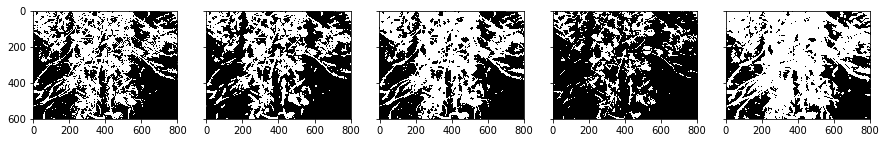

In [10]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

# Normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


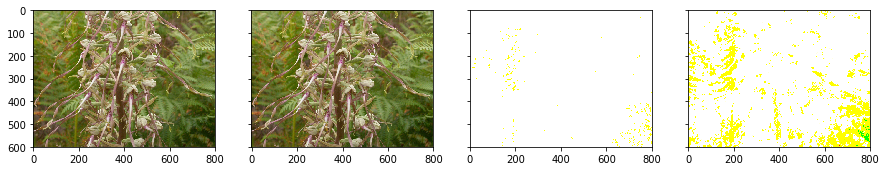

In [11]:
norm1_image = image/255
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

# Augmentations

The following two types of augmentation techniques is used to augment the existing data set:

+ Linear transformations
+ Affine transformations

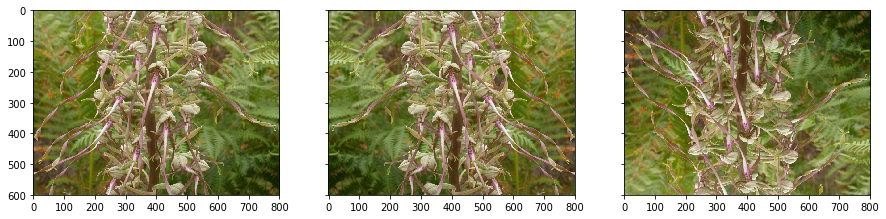

In [12]:
from skimage import transform as tf

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

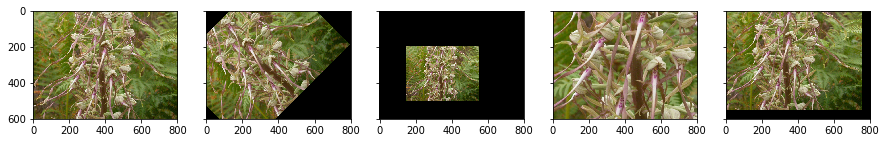

In [13]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = tf.warp(image, rot_matrix)

# scaling 
scale_transforms = tf.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = tf.warp(image, scale_matrix)

scale_transforms = tf.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = tf.warp(image, scale_matrix)

# translation
transaltion_transforms = tf.AffineTransform(translation=(50, 50))
translated_image = tf.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


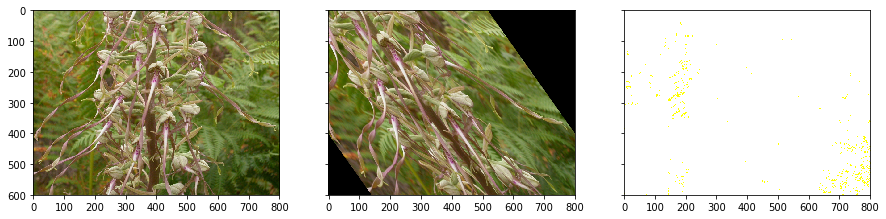

In [14]:
# shear transforms
shear_transforms = tf.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = tf.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

# Network Building

The resnet architecture is used to build the CNN network. Importing the architect from resnet.py

In [19]:
import resnet

# image size and channels
img_channels = 3
img_rows = 100
img_cols = 100

# number of classes
nb_classes = 2

# Data Generator

The code below sets up a custom data generator which is slightly different than the one that comes with the keras API for increased customizability.

We have the training data stored in $n$ directories (if there are $n$ classes). For a given batch size, we want to generate batches of data points and feed them to the model.

The first for loop 'globs' through each of the classes (directories). For each class, it stores the path of each image in the list paths. In training mode, it subsets paths to contain the first 80% images; in validation mode it subsets the last 20%. In the special case of an ablation experiment, it simply subsets the first ablation images of each class.

We store the paths of all the images (of all classes) in a combined list self.list_IDs. The dictionary self.labels contains the labels (as key:value pairs of path: class_number (0/1)).

After the loop, we call the method on_epoch_end(), which creates an array self.indexes of length self.list_IDs and shuffles them (to shuffle all the data points at the end of each epoch).

The _getitem_ method uses the (shuffled) array self.indexes to select a batch_size number of entries (paths) from the path list self.list_IDs.

The method __data_generation returns the batch of images as the pair X, y where X is of shape (batch_size, height, width, channels) and y is of shape (batch size, ). __data_generation also does some preprocessing - it normalises the images (divides by 255) and crops the center 100 x 100 portion of the image. Thus, each image has the shape (100, 100, num_channels). If any dimension (height or width) of an image less than 100 pixels, that image is deleted.

In [20]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# Running Ablation Experiments

Running some experiments first to check whether the net is fitting on a small dataset or not

## Checking that the network is working

First, trying to fit the net on only a few images and just one epoch. Since ablation=100 is specified. 100 images of each class are used, so total number of batches is np.floor(200/32)=6

DataGenerator class 'inherits' from the keras.utils.Sequence class, so it has the functionailities of the base keras.utils.Sequence class( such as the model.fit_generator method)

In [17]:
# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

# Hyperparameter Tuning

Following hyperparameters are tuned :

* Learning Rate & Variation + Optimisers
* Augmentation Techniques

The validation loss is tracked with increasing epochs for various of a hyperparameter

In [ ]:
# generic way to create custom callback
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Below, a custom Keras callback to append the loss to a list at the end of every epoh is created

In [ ]:
plt.imshow(image)

In [ ]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

In [ ]:

def _compute_grads(model, input_array):
    grads_fn = K.gradients(model.output, model.input)[0]
    compute_fn = K.function([model.input, K.learning_phase()], [grads_fn])
    return compute_fn([np.array([input_array]), 0])[0][0]

In [ ]:
plt.imshow(img)